### **Imports**
***

In [116]:
import pandas as pd
import json
import ast
import re
import os
import math
import numpy as np
import sys
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
from scipy.spatial.distance import cdist
from gensim.models import FastText, Word2Vec
from typing import List
from collections import Counter
from glob import glob
from difflib import SequenceMatcher
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from pandas.errors import SettingWithCopyWarning
from sklearn.decomposition import PCA
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

### **Read Player Feature Data**
---

In [117]:
ground_truth_player_features_fp = '/playpen-storage/levlevi/player-re-id/src/data/raw_features.json'
ground_truth_player_features_df_fp = '/playpen-storage/levlevi/player-re-id/src/data/team_rosters_df.csv'
with open(ground_truth_player_features_fp, 'r') as f:
    ground_truth_player_features_dict = json.load(f)
ground_truth_player_features_df = pd.read_csv(ground_truth_player_features_df_fp)

In [118]:
# which features are redundant?
ground_truth_player_features_subset_df = ground_truth_player_features_df[['team_id', 'player_id', 'jersey_number']]

# add feature to indicate if player is in game
ground_truth_player_features_subset_df['player_in_game'] = [False] * len(ground_truth_player_features_subset_df)

### **Format Tracklet Predicted Features**
***

In [119]:
TRESH = 0.998

# human labels for 50 tracklet test set
with open('/playpen-storage/levlevi/player-re-id/src/data/_50_game_reid_benchmark_/annotations.json') as f:
    tracklet_human_annotations_dict = json.load(f)
    
# convert raw florence preditions to dict
florence_predictions_fp = '/playpen-storage/levlevi/player-re-id/src/data/florence_100_track_bm_results.json'
def read_florence_predictions(fp):
    with open(fp, 'r') as f:
        florence_predictions = f.readlines()
    predictions = {}
    for p in florence_predictions:
        key = p.split(':')[0]
        values = ast.literal_eval('{' + '{'.join(p.split('{')[1: ]))
        predicted_vals = [values[k][0] for k in values.keys() if values[k][1] > TRESH]
        predictions[key] = predicted_vals
    return predictions
predicted_tracklet_features_florence_dict = read_florence_predictions(florence_predictions_fp)

# roster metadata
with open("/playpen-storage/levlevi/player-re-id/src/data/raw_features.json", 'r') as f:
    ground_truth_player_features_dict = json.load(f)

In [120]:
JERSEY_NUMBER_THRESH = 30

# get most common race from list
def get_maj_race(races):
    if len(races) == 0:
        return None
    counter = Counter(races)
    return counter.most_common(1)[0][0]

# get most common player postion from list
def get_maj_position(positions):
    if len(positions) == 0:
        return None
    counter = Counter(positions)
    return counter.most_common(1)[0][0]

# get most common jersey number from list
def get_maj_jersey_number(jersey_numbers):
    if len(jersey_numbers) < JERSEY_NUMBER_THRESH:
        return None
    counter = Counter(jersey_numbers)
    return counter.most_common(1)[0][0]

In [121]:
HUDL_GAME_LOGS_DIR = '/mnt/sun/levlevi/nba-plus-statvu-dataset/hudl-game-logs'
# id: fp
game_logs_map = {
    f.split('.')[-2]: os.path.join(HUDL_GAME_LOGS_DIR, f) for f in os.listdir(HUDL_GAME_LOGS_DIR)
}

def calculate_string_similarity_score(string_one, string_two):
    return SequenceMatcher(None, string_one, string_two).ratio()

def find_closest_player_id(player_name: str) -> int:
    best_similarity = -float('inf')
    best_player_id_match = None
    for _, team_data in ground_truth_player_features_dict.items():
        for player, player_data in team_data['players'].items():
            # convert player name to full name
            full_name = player if ',' not in player else ' '.join(reversed(player.split(',')))
            player_id = player_data['player_id']
            similarity = calculate_string_similarity_score(full_name, player_name)
            if similarity > best_similarity:
                best_similarity = similarity
                best_player_id_match = player_id
    if best_player_id_match is None:
        raise ValueError(f"No matching player found for the name: {player_name}")
    return int(best_player_id_match)

def get_candidate_player_ids(tracklet_fp: str) -> List[str]:
    game_id = tracklet_fp.split('/')[-2].split('_')[0]
    period = tracklet_fp.split('/')[-2].split('_')[-1].split('period')[1][0]
    period = int(period)
    df = pd.read_csv(game_logs_map[game_id], delimiter=';')
    df['is_period'] = df['half'].apply(lambda x: x == period)
    df_period_matched = df[df['is_period'] == True]
    
    unique_player_ids = set()
    unique_player_names = set(df['player_name'].unique())
    unique_player_names = set(df_period_matched['player_name'].unique())
    unique_player_names_no_nan = {p for p in unique_player_names if not pd.isna(p)}
    for pn in unique_player_names_no_nan:
        unique_player_ids.add(find_closest_player_id(pn))
    return unique_player_ids

def get_candidate_team_ids(tracklet_fp: str) -> List[str]:
    team_one_name = tracklet_fp.split('/')[-2].split('_')[3].replace(" ", "_")
    team_two_name = tracklet_fp.split('/')[-2].split('_')[5].replace(" ", "_")
    team_one_id = ground_truth_player_features_dict[team_one_name]['team_id']
    team_two_id = ground_truth_player_features_dict[team_two_name]['team_id']
    return [team_one_id, team_two_id]

# all rows in predictions df
rows = []
for tracklet_fp, raw_predictions in predicted_tracklet_features_florence_dict.items():
    # get team ids from file path
    predicted_jersey_numbers = []
    candidate_team_ids = get_candidate_team_ids(tracklet_fp)
    candidate_players_ids = get_candidate_player_ids(tracklet_fp)
    # get jersey numbers
    for jersey_number in raw_predictions:
        predicted_jersey_numbers.append(jersey_number)
    # find most common jersey number
    maj_jersey_number = get_maj_jersey_number(predicted_jersey_numbers)
    temp_row = [tracklet_fp, maj_jersey_number, candidate_team_ids, candidate_players_ids]
    rows.append(temp_row)
    
# add all rows to df
all_tracklet_features = pd.DataFrame(rows, columns=['tracklet_file_path', 'predicted_jersey_number', 'candidate_team_ids', 'candidate_player_ids'])
all_tracklet_features.head()

,tracklet_file_path,predicted_jersey_number,candidate_team_ids,candidate_player_ids
0,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,4,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1..."
1,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,1,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1..."
2,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,None,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1..."
3,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,None,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1..."
4,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,5,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1..."


In [122]:
human_labels = []
for file_path in all_tracklet_features['tracklet_file_path']:
    video_name = file_path.split('/')[-2]
    subtrack = file_path.split('/')[-1]
    human_label = tracklet_human_annotations_dict[video_name]['tracks'][subtrack]['human_annotation']
    human_labels.append(human_label)
    
all_tracklet_features['human_label'] = human_labels

In [139]:
JERSEY_VECTOR_SIZE = 500

# 1. generate ground truth player embeddings
jersey_numbers = list(set(ground_truth_player_features_subset_df['jersey_number'].astype(str)))
sentences = [[char for char in number] for number in jersey_numbers]
model = FastText(sentences, vector_size=JERSEY_VECTOR_SIZE, window=1, min_count=1, sg=1)

In [140]:
unique_team_ids = list(ground_truth_player_features_dict[k]['team_id'] for k in ground_truth_player_features_dict)
unique_team_ids_idx_map = {str(int(team_id)): idx for idx, team_id in enumerate(unique_team_ids)}

unique_player_ids_arr = sorted(ground_truth_player_features_subset_df['player_id'].unique())
unique_player_ids_idx_map = {player_id: idx for idx, player_id in enumerate(unique_player_ids_arr)}

In [141]:
def get_jersey_number_embed(number: str):
    if not number:
        return [-sys.maxsize + 1] * JERSEY_VECTOR_SIZE
    return model.wv[number]

def get_team_id_embed(team_ids: List[str]):
    embedding = np.zeros(len(unique_team_ids_idx_map))
    for team_id in team_ids:
        team_idx = unique_team_ids_idx_map[str(team_id)]
        embedding[team_idx] = 1
    return embedding
    
def get_player_id_embed(player_ids: List[str]):
    embedding = np.zeros(len(unique_player_ids_idx_map))
    for player_id in player_ids:
        player_idx = unique_player_ids_idx_map[player_id]
        embedding[player_idx] = 1
    return embedding

def normalize_embeddings(embeddings):
    return normalize(embeddings, norm='l2')

In [142]:
# flatten the player IDs and then one-hot encode
player_id_encoder = OneHotEncoder(categories=[unique_player_ids_arr], sparse=False)
player_id_encoder.fit(np.array(unique_player_ids_arr).reshape(-1, 1))  # fit the encoder

def get_player_id_embed_one_hot(player_ids: List[str], encoder):
    encoded = encoder.transform(np.array(list(player_ids)).reshape(-1, 1))
    return encoded.sum(axis=0)  # sum to get a single vector representing all candidate IDs
    
ground_truth_player_embeddings = []
for row in ground_truth_player_features_subset_df.itertuples():
    jersey_number = row.jersey_number
    # a. get jersey number embed
    jersey_number_embedding = get_jersey_number_embed(jersey_number)
    # b. get player id embeds
    player_ids = [row.player_id]
    player_id_embedding = get_player_id_embed_one_hot(player_ids, player_id_encoder)
    # c. get concatinated embedding
    concatinated_embedding = np.hstack([jersey_number_embedding, player_id_embedding])
    ground_truth_player_embeddings.append(concatinated_embedding)
    
# normalize
# ground_truth_player_embeddings = normalize_embeddings(ground_truth_player_embeddings)
ground_truth_player_features_subset_df['embedding'] = [np.ravel(embedding) for embedding in ground_truth_player_embeddings]
ground_truth_player_features_subset_df.head()

,team_id,player_id,jersey_number,player_in_game,embedding
0,1610612738,202340,0,False,"[-9.223372036854776e+18, -9.223372036854776e+1..."
1,1610612738,203109,99,False,"[0.0005501051782630384, -0.0004608097951859236..."
2,1610612738,203089,30,False,"[-0.00041807923116721213, -0.00066372868604958..."
3,1610612738,1626154,28,False,"[-0.0005988343618810177, -0.000336653756676241..."
4,1610612738,201973,8,False,"[-0.00183630280662328, -0.0006581409252248704,..."


In [143]:
# 2. generated tracklet embeddings
tracklet_embeddings = []
for row in all_tracklet_features.itertuples():
    jersey_number = row.predicted_jersey_number
    candidate_player_ids = row.candidate_player_ids
    # a. get jersey number embed
    jersey_number_embedding = get_jersey_number_embed(jersey_number)
    # b. get player id embeds
    player_ids_embedding = get_player_id_embed_one_hot(list(candidate_player_ids), player_id_encoder)
    # c. get concatinated embedding
    concatinated_embedding = np.concatenate([jersey_number_embedding, player_ids_embedding])
    tracklet_embeddings.append(concatinated_embedding)
    
# normalize
# tracklet_embeddings = normalize_embeddings(tracklet_embeddings)
all_tracklet_features['embedding'] = [np.ravel(embedding) for embedding in tracklet_embeddings]
all_tracklet_features.head()

,tracklet_file_path,predicted_jersey_number,candidate_team_ids,candidate_player_ids,human_label,embedding
0,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,4,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1...",NaN,"[-0.0013422053307294846, 0.0008337716571986675..."
1,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,1,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1...",201933.0,"[-0.000352953327819705, -0.0005789406131953001..."
2,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,None,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1...",203114.0,"[-9.223372036854776e+18, -9.223372036854776e+1..."
3,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,None,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1...",203114.0,"[-9.223372036854776e+18, -9.223372036854776e+1..."
4,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,5,"[1610612749, 1610612746]","{201601, 203948, 203953, 200755, 1718, 2746, 1...",200755.0,"[-5.582411540672183e-05, 0.0006308546871878207..."


In [144]:
# euclidean Distance
def euclidean_distance(vec1: List[float], vec2: List[float]) -> float:
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(vec1, vec2)))

# cosine Similarity
def cosine_similarity(vec1: List[float], vec2: List[float]) -> float:
    dot_product = sum(x * y for x, y in zip(vec1, vec2))
    magnitude1 = math.sqrt(sum(x ** 2 for x in vec1))
    magnitude2 = math.sqrt(sum(y ** 2 for y in vec2))
    if magnitude1 == 0 or magnitude2 == 0:
        return 0.0  # Avoid division by zero
    return dot_product / (magnitude1 * magnitude2)

def pearson_correlation(vec1: List[float], vec2: List[float]) -> float:
    n = len(vec1)
    sum1 = sum(vec1)
    sum2 = sum(vec2)
    sum1_sq = sum(x ** 2 for x in vec1)
    sum2_sq = sum(y ** 2 for y in vec2)
    product_sum = sum(x * y for x, y in zip(vec1, vec2))
    
    numerator = product_sum - (sum1 * sum2 / n)
    denominator = math.sqrt((sum1_sq - sum1 ** 2 / n) * (sum2_sq - sum2 ** 2 / n))
    if denominator == 0:
        return 0.0  # Avoid division by zero
    return numerator / denominator

### **Match Tracklet Embeddings to Candidates**
***

In [145]:
# initialize the result list with NaNs
reidentified_tracklet_player_ids = [np.nan] * len(human_labels)

# extract ground truth player embeddings and IDs
ground_truth_embeddings = np.vstack(ground_truth_player_features_subset_df['embedding'].values)
ground_truth_player_ids = ground_truth_player_features_subset_df['player_id'].values
best_distances = []

# iterate over tracklet features
for tracklet_index, tracklet_row in enumerate(all_tracklet_features.itertuples()):
    # all candidate player ids
    candidates = tracklet_row.candidate_player_ids
    tracklet_embedding = np.array(tracklet_row.embedding).reshape(1, -1)
    # compute distances to all ground truth embeddings
    distances = cdist(tracklet_embedding, ground_truth_embeddings, metric='euclidean')
    best_match_idx = np.argmin(distances)
    best_distance = distances[0][best_match_idx]
    best_distances.append(best_distance)
    best_match_player_id = ground_truth_player_ids[best_match_idx]
    # assign the best match player ID
    # if best_match_player_id in candidates:
    reidentified_tracklet_player_ids[tracklet_index] = best_match_player_id

In [146]:
def normalize_distances(distances: List[float]) -> List[float]:
    std = np.std(distances)
    mean = np.mean(distances)
    return (distances - mean) / std

best_distances_norm = normalize_distances(best_distances)

In [147]:
# create a dataframe with all predictions
predictions_computed = pd.DataFrame({'tracklet_file_path': all_tracklet_features['tracklet_file_path'], 'human_label': human_labels, 'prediction': reidentified_tracklet_player_ids})
predictions_computed['normalized_distance'] = best_distances_norm

In [152]:
actual_jersey_numbers = []
for player_id in predictions_computed['human_label']:
    if not player_id > 0:
        actual_jersey_numbers.append(None)
        continue
    mask = ground_truth_player_features_subset_df['player_id'] == int(player_id)
    masked_df = ground_truth_player_features_subset_df[mask]
    act_jn = masked_df['jersey_number']
    actual_jersey_numbers.append(act_jn.values[0])
    
predictions_computed_with_jersey_numbers = predictions_computed.copy()
predictions_computed_with_jersey_numbers['actual_jersey_number'] = actual_jersey_numbers
predictions_computed_with_jersey_numbers['predicted_jersey_number'] = all_tracklet_features['predicted_jersey_number']
predictions_computed_with_jersey_numbers['file_path_preds'] = list(predicted_tracklet_features_florence_dict.keys())
predictions_computed_with_jersey_numbers['matching_file_paths'] = predictions_computed_with_jersey_numbers['file_path_preds'] == predictions_computed_with_jersey_numbers['tracklet_file_path']

In [153]:
predictions_computed_with_jersey_numbers

,tracklet_file_path,human_label,prediction,normalized_distance,actual_jersey_number,predicted_jersey_number,file_path_preds,matching_file_paths
0,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,NaN,200755,0.455062,NaN,4,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
1,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,201933.0,202362,0.455065,32.0,1,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
2,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,203114.0,202340,1.769127,22.0,None,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
3,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,203114.0,202340,1.769127,22.0,None,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
4,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,200755.0,203487,0.455063,4.0,5,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
5,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,200755.0,201564,0.455058,4.0,3,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
6,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,201933.0,201564,0.455058,32.0,3,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
7,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,203114.0,202340,1.769127,22.0,None,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
8,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,200755.0,202340,1.769127,4.0,None,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True
9,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,203114.0,202340,1.769127,22.0,None,/mnt/opr/levlevi/player-re-id/src/data/_50_gam...,True


### **Evaluate & Vizualize Results**
***

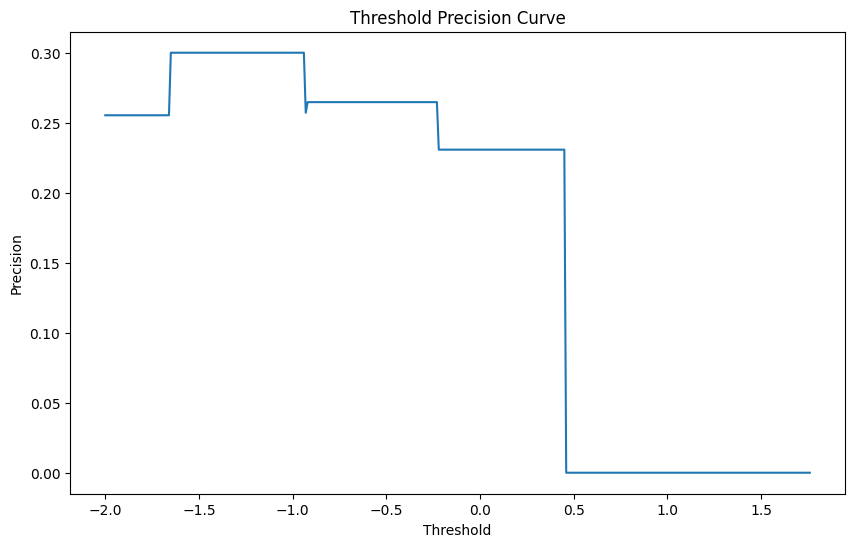

In [137]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_predictions(predictions):
    matched_mask = predictions['human_label'] == predictions['prediction']
    predictions_matched = predictions[matched_mask]

    # Drop rows with NaN values
    predictions_no_na = predictions.dropna()
    predictions_no_na['human_label'] = predictions_no_na['human_label'].astype(int)
    predictions_no_na['prediction'] = predictions_no_na['prediction'].astype(int)

    # Compute accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(predictions_no_na['human_label'], predictions_no_na['prediction'])
    precision = precision_score(predictions_no_na['human_label'], predictions_no_na['prediction'], average='weighted')
    recall = recall_score(predictions_no_na['human_label'], predictions_no_na['prediction'], average='weighted')
    f1 = f1_score(predictions_no_na['human_label'], predictions_no_na['prediction'], average='weighted')

    return accuracy, precision, recall, f1

precision_results = []
for thresh in np.arange(-2.0, 2.0, 0.01):
    predictions_computed_thresh = predictions_computed[predictions_computed['normalized_distance'] > thresh]
    accuracy, precision, recall, f1 = evaluate_predictions(predictions_computed_thresh)
    precision_results.append((thresh, precision))
    
# plot precision thresh curve
plt.figure(figsize=(10, 6))
plt.plot([x[0] for x in precision_results], [x[1] for x in precision_results])
plt.title('Threshold Precision Curve')
plt.xlabel('Threshold')
plt.ylabel('Precision');
plt.show();

In [138]:
matched_mask = predictions_computed['human_label'] == predictions_computed['prediction']
predictions_matched = predictions_computed[matched_mask]
len(predictions_matched)

7

In [135]:
# Combine embeddings for t-SNE
combined_embeddings = np.vstack((ground_truth_embeddings, tracklet_embeddings))

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(combined_embeddings)


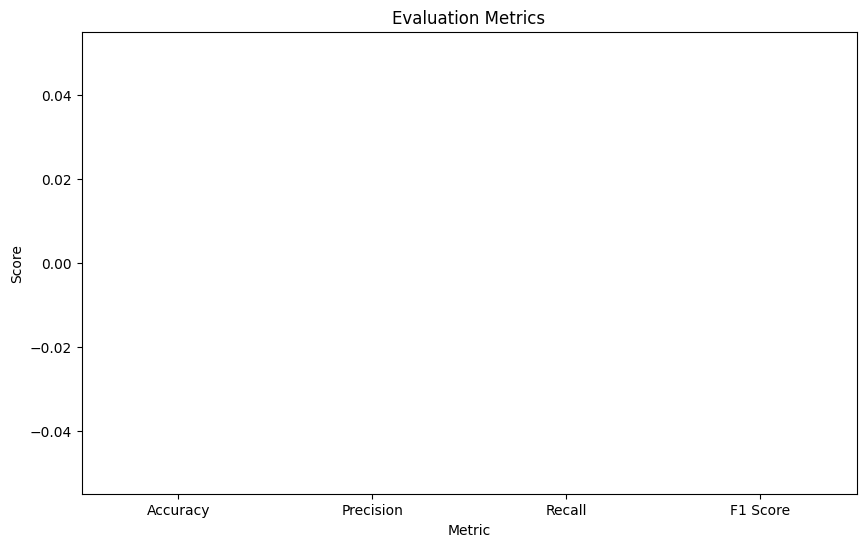

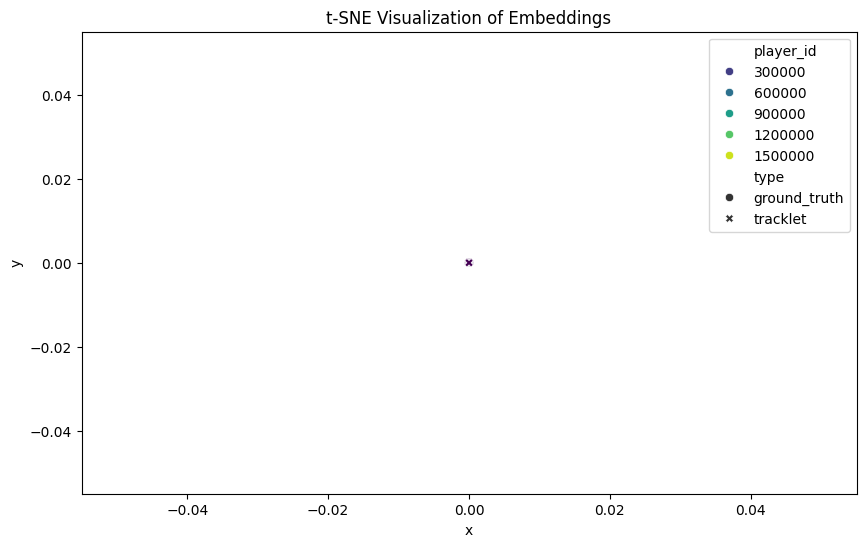

In [136]:
# Split t-SNE results back into ground truth and tracklet embeddings
tsne_ground_truth = tsne_results[:len(ground_truth_embeddings)]
tsne_tracklets = tsne_results[len(tracklet_embeddings):]

# Create a dataframe with t-SNE results
tsne_df_ground_truth = pd.DataFrame(tsne_ground_truth, columns=['x', 'y'])
tsne_df_ground_truth['type'] = 'ground_truth'
tsne_df_ground_truth['player_id'] = ground_truth_player_features_subset_df['player_id']

tsne_df_tracklets = pd.DataFrame(tsne_tracklets, columns=['x', 'y'])
tsne_df_tracklets['type'] = 'tracklet'
tsne_df_tracklets['player_id'] = [1] * len(tsne_df_tracklets)  # Tracklet IDs can be replaced with actual labels if available

tsne_df = pd.concat([tsne_df_ground_truth, tsne_df_tracklets])

# Visualize the evaluation results
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.title('Evaluation Metrics')
plt.show()

# Visualize embeddings using t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='player_id', style='type', palette='viridis')
plt.title('t-SNE Visualization of Embeddings')
plt.show()